In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    VotingRegressor,
    StackingRegressor
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

1. Data Loading (5 Marks)
Load the chosen dataset into your environment and display the first few rows along with the shape to verify correctness.


In [13]:
dataset = "../data/vgsales.csv"

In [14]:
df = pd.read_csv(dataset)

df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [15]:
unique_platforms = df['Platform'].unique()
unique_genres = df['Genre'].unique()
unique_publishers = df['Publisher'].unique()

In [16]:
print("Unique Platforms:", unique_platforms)
print("Unique Genres:", unique_genres)


Unique Platforms: ['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' '3DS' 'PS4' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'GC' 'WiiU' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
Unique Genres: ['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy']


In [17]:
print("Unique Publishers:", unique_publishers)

Unique Publishers: ['Nintendo' 'Microsoft Game Studios' 'Take-Two Interactive'
 'Sony Computer Entertainment' 'Activision' 'Ubisoft' 'Bethesda Softworks'
 'Electronic Arts' 'Sega' 'SquareSoft' 'Atari' '505 Games' 'Capcom'
 'GT Interactive' 'Konami Digital Entertainment'
 'Sony Computer Entertainment Europe' 'Square Enix' 'LucasArts'
 'Virgin Interactive' 'Warner Bros. Interactive Entertainment'
 'Universal Interactive' 'Eidos Interactive' 'RedOctane' 'Vivendi Games'
 'Enix Corporation' 'Namco Bandai Games' 'Palcom' 'Hasbro Interactive'
 'THQ' 'Fox Interactive' 'Acclaim Entertainment' 'MTV Games'
 'Disney Interactive Studios' nan 'Majesco Entertainment' 'Codemasters'
 'Red Orb' 'Level 5' 'Arena Entertainment' 'Midway Games' 'JVC'
 'Deep Silver' '989 Studios' 'NCSoft' 'UEP Systems' 'Parker Bros.' 'Maxis'
 'Imagic' 'Tecmo Koei' 'Valve Software' 'ASCII Entertainment' 'Mindscape'
 'Infogrames' 'Unknown' 'Square' 'Valve' 'Activision Value' 'Banpresto'
 'D3Publisher' 'Oxygen Interactive' 'Red

In [18]:
df.shape

(16598, 11)

2. Data Preprocessing (10 Marks)
Perform and document at least 5 distinct preprocessing steps (e.g., handling missing values, encoding, scaling, outlier detection, feature engineering).


In [19]:
df.isnull().sum().sort_values(ascending=False)

Year            271
Publisher        58
Rank              0
Platform          0
Name              0
Genre             0
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [20]:
df["Year"] = df["Year"].fillna(df["Year"].median())

df["Publisher"] = df["Publisher"].fillna("Unknown")

The dataset contains a small number of missing values in the Year and Publisher columns. These values are not large enough to remove the affected rows. The Year column is filled with the median value, and missing values in the Publisher column are filled with “Unknown” to keep the dataset complete.

In [21]:
df.columns = df.columns.str.strip()

In [22]:
df.columns.tolist()

['Rank',
 'Name',
 'Platform',
 'Year',
 'Genre',
 'Publisher',
 'NA_Sales',
 'EU_Sales',
 'JP_Sales',
 'Other_Sales',
 'Global_Sales']

In [23]:
%pip install ydata-profiling

Note: you may need to restart the kernel to use updated packages.


In [24]:
from ydata_profiling import ProfileReport


output_path = "output.html"

if not os.path.exists(output_path):
    report = ProfileReport(df)
    report.to_file(output_path)
else:
    print("Profile report already exists. Skipping generation.")

Profile report already exists. Skipping generation.


In [25]:
drop_cols = [
    "Rank",
    "Name",
    "NA_Sales",
    "EU_Sales",
    "JP_Sales",
    "Other_Sales"
]

df = df.drop(columns=drop_cols)

Rank and Name columns are removed as they are not useful for analysis. Regional sales columns are also dropped because Global_Sales is already derived from them.

In [26]:
cols = df.columns.tolist()

cols

['Platform', 'Year', 'Genre', 'Publisher', 'Global_Sales']

In [27]:
len(cols)

5

In [28]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

In [29]:
numerical_cols.to_list()

['Year', 'Global_Sales']

In [30]:
categorical_cols.to_list()

['Platform', 'Genre', 'Publisher']

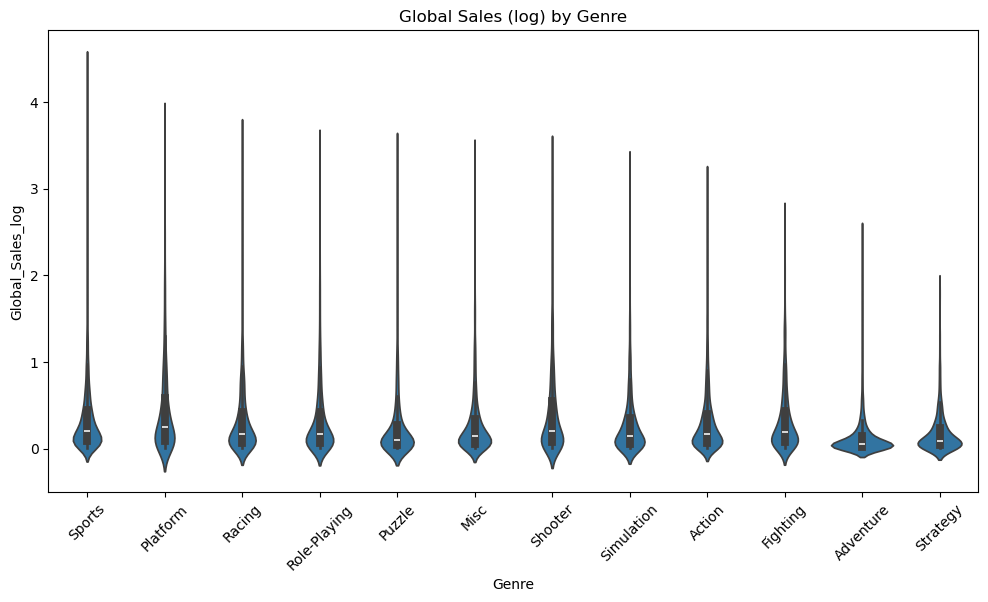

In [31]:
df["Global_Sales_log"] = np.log1p(df["Global_Sales"])

plt.figure(figsize=(12,6))
sns.violinplot(x="Genre", y="Global_Sales_log", data=df)
plt.xticks(rotation=45)
plt.title("Global Sales (log) by Genre")
plt.show()

The violin plot shows that Sports, Platform, and Racing are the top-selling genres, while Strategy and Puzzle games sell the least. Sports games have a few exceptional blockbusters, but most genres follow a long-tail pattern where most titles sell moderately and only a few become major hits.

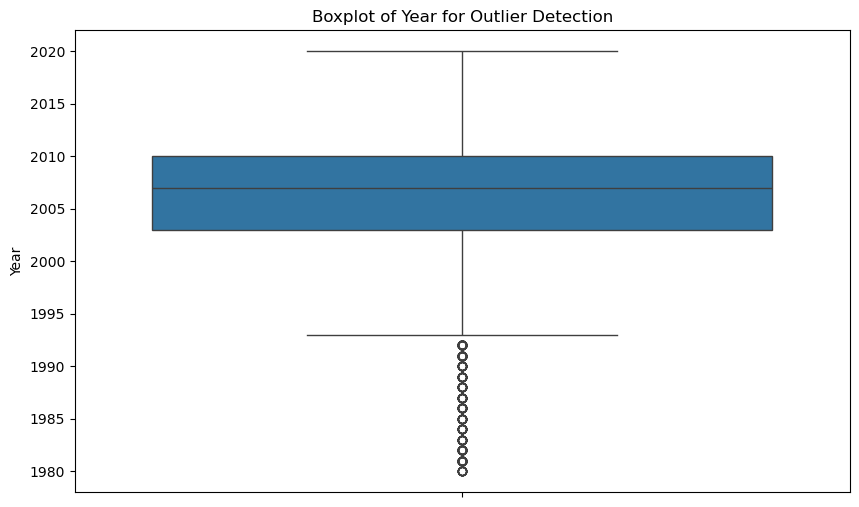

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df["Year"]) 
plt.xticks(rotation=90) 
plt.title("Boxplot of Year for Outlier Detection") 
plt.show() 

The boxplot shows that most games were sold between 2004 and 2010, while a smaller number of games were sold between 1980 and 1995. Although these older games could be considered outliers, they are valid data points, as they reflect the trend of purchasing vintage games.

In [33]:
X = df.drop("Global_Sales", axis=1)
y = df["Global_Sales"]

In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

3. Pipeline Creation (10 Marks)
Construct a standard Machine Learning pipeline that integrates preprocessing and the model


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [36]:
rfr = RandomForestRegressor(
    n_estimators=100, random_state=42, n_jobs=-1, verbose=0)

In [37]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", rfr)
])

4. Primary Model Selection (5 Marks)
Choose a suitable algorithm and justify why this specific model was selected for the dataset.


RandomForestRegressor is selected for this regression task because it is robust and can model non-linear relationships effectively. It works well with mixed data types, handles skewed target distributions, and reduces overfitting through ensemble learning, making it a strong choice for predicting video game sales.

5. Model Training (10 Marks)
Train your selected model using the training portion of your dataset.


In [38]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Platform', 'Genre', 'Publisher'], dtype='object'))])),
                ('classifier',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

In [39]:
y_pred = pipeline.predict(X_test)

In [40]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Initial Model RMSE: {rmse:.3f}")
print(f"Initial Model R2: {r2:.3f}")

Initial Model RMSE: 1.949
Initial Model R2: 0.096


With an RMSE of 1.949 and an R² of 0.096, the model captures some patterns in the data, but overall performance is poor. Further tuning of the model can improve its performance.

6. Cross-Validation (10 Marks)
Apply Cross-Validation  to assess robustness and report the average score with standard deviation.


In [41]:

cv_scores = cross_val_score(
    pipeline, X_train, y_train, cv=5, scoring="r2"
)

In [42]:
print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Average R2: {cv_scores.mean():.3f}")
print(f"Standard Deviation: {cv_scores.std():.3f}")

Cross-Validation R2 Scores: [ 0.08398736  0.16226269 -0.00458114  0.11144884  0.11775017]
Average R2: 0.094
Standard Deviation: 0.055


The cross-validation results show R² scores ranging from −0.0046 to 0.1623, with an average R² of 0.094 and a standard deviation of 0.055. This indicates that the model has consistently low predictive performance across different data splits and does not generalize well. With further hyperparameter tuning, the model’s performance can be improved.

7. Hyperparameter Tuning (10 Marks)
Optimize your model using search methods displaying both the parameters tested and the best results found.


In [43]:


lr = LinearRegression()

gbr = GradientBoostingRegressor(
    n_estimators=100,
    random_state=42)

In [44]:


voting_reg = VotingRegressor(
    estimators=[
        ('lr', lr),
        ('rf', rfr),
        ('gb', gbr)
    ]
)

In [45]:


stacking_reg = StackingRegressor(
    estimators=[

        ('rf', rfr),
        ('gb', gbr)
    ], final_estimator=Ridge()
)

In [46]:
model_to_train = {
    'Linear Regression' : lr,
    'Random Forest' : rfr,
    'Gradient Boosting': gbr,
    'Voting Ensemble ' : voting_reg,
    'Stacking Ensemble ' : stacking_reg

}

In [47]:


result = []

for name, model in model_to_train.items():
    # create full pipeline with preprocessor
    pipe = Pipeline(
        [
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )

    # train

    pipe.fit(X_train, y_train)

    # predict

    y_pred = pipe.predict(X_test)

    # Evaluate

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    result.append({
        "Model": name,
        "R2 Score": r2,
        "RMSE": rmse,
        "MAE": mae
    })

results_df = pd.DataFrame(result).sort_values("R2 Score", ascending=False)

print(results_df)

                Model  R2 Score      RMSE       MAE
3    Voting Ensemble   0.111471  1.932106  0.516833
4  Stacking Ensemble   0.106967  1.936997  0.527000
1       Random Forest  0.096239  1.948596  0.521998
2   Gradient Boosting  0.094472  1.950501  0.540533
0   Linear Regression  0.087048  1.958480  0.559084


In [48]:
best_model_name = results_df.iloc[0]['Model']
best_model = model_to_train[best_model_name]

In [49]:
best_model

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('rf',
                             RandomForestRegressor(n_jobs=-1, random_state=42)),
                            ('gb', GradientBoostingRegressor(random_state=42))])

In [50]:
param_grid = {
    "model__weights": [
        None,
        [1, 1, 1],
        [2, 1, 1],
        [1, 2, 1],
        [1, 1, 2],
        [2, 2, 1],
        [1, 2, 2],
    ],
   
}

In [51]:


grid_search = GridSearchCV(
    estimator=Pipeline([
        ("preprocessor", preprocessor),
        ("model", best_model)
    ]),
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    return_train_score=True
)

In [52]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['Platform', 'Genre', 'Publisher'], dtype='object'))])),
                                       ('model',
                                        VotingRegressor(estimators=[('lr',
                                                                     LinearRegression()),
                                                                    ('rf',
                                                                     RandomForestRegressor(n_jobs=-1,
                                                                                           random_state=42)),
                                                                    ('gb',
                                                                     GradientBoostingRegressor(random_state=42))]))]),
             n_jobs=-1,
             param_grid={'model__weights': [None, [1, 1, 1], [2, 1, 1],
                                            [1, 2, 1], [1, 1, 2], [2, 2, 1],
                                            [1, 2, 2]]},
             return_train_score=True, scoring='r2')

In [53]:
results_df = pd.DataFrame(grid_search.cv_results_)[
    ["params", "mean_test_score", "std_test_score", "mean_train_score"]
].sort_values(by="mean_test_score", ascending=False)

results_df

,params,mean_test_score,std_test_score,mean_train_score
0,{'model__weights': None},0.172917,0.036424,0.304642
1,"{'model__weights': [1, 1, 1]}",0.172917,0.036424,0.304642
5,"{'model__weights': [2, 2, 1]}",0.172645,0.037589,0.313071
4,"{'model__weights': [1, 1, 2]}",0.171161,0.035109,0.292202
2,"{'model__weights': [2, 1, 1]}",0.171013,0.030892,0.276607
6,"{'model__weights': [1, 2, 2]}",0.170183,0.040294,0.323206
3,"{'model__weights': [1, 2, 1]}",0.167650,0.042253,0.337185


In [54]:
best_model_tuned = grid_search.best_estimator_

In [55]:
y_pred = best_model_tuned.predict(X_test)

In [56]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
cv_r2_mean = cross_val_score(best_model_tuned, X_train, y_train, cv=5, scoring='r2').mean()

In [60]:
results_df = pd.DataFrame({
    "Metric": ["Best Parameters","R2 Score", "RMSE", "MAE", "Mean CV R2"],
    "Value": [grid_search.best_params_,r2, rmse, mae, cv_r2_mean]
})

results_df

,Metric,Value
0,Best Parameters,{'model__weights': None}
1,R2 Score,0.111471
2,RMSE,1.932106
3,MAE,0.516833
4,Mean CV R2,0.172917


The Voting Regressor with weights=None gives the best result, achieving an R² score of 0.1729. This is a significant improvement compared to the initial model. Hyperparameter tuning helped maximize the model’s performance, but the overall result still falls short of expectations. This is mainly due to the lack of important features in the original dataset. Based on the available features, this is the best performance that can be achieved.

In [59]:


model_path = "../models/model.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)

with open(model_path, "wb") as f:

    pickle.dump(best_model_tuned, f)